# Figure comparing Sigma_SFR to pressures and weights (Figure 12 of Jeffreson+ 2024)

In [1]:
import numpy as np
import h5py
from PRFMData import PRFMDataset
import astro_helper as ah
import Atlas3D_MASSIVE_helper as AMh

from astropy.io import ascii as asciitable
from astropy.table import Table
import density_contours

import pickle
from pathlib import Path
import glob, os, re, sys
import configparser
config = configparser.ConfigParser()
config.read('config_pressures-SFRs.ini')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')

In [2]:
labels = [r"$\mathbf{M_*=10^{10}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{10.5}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11.5}{\rm M}_\odot}$",
          r"Milky Way-like",
          r"NGC~300-like",]
colors = [plt.cm.magma((i+1)/5) for i in range(4)]
colors.append('#3C3C3C')
colors.append('#5E9F87')

In [3]:
tags = ['ETG-vlM', 'ETG-lowM', 'ETG-medM', 'ETG-hiM', 'MW', 'NGC300']
Rmaxs_kpc = [config[tag].getfloat('RMAX') for tag in tags]
Rmaxs_kpc = [1.5 if elem==2. else elem for elem in Rmaxs_kpc] # cut to actual max size of ETGs

# simulation data

In [14]:
Rbin_centers, data_weights, data_PSFRs = [], [], []
for tag in tags:
    filesavedir = Path(config[tag]['ROOT_DIR']) / config[tag]['SUBDIR']

    # weight from this array (temperature threshold here has no impact)
    filesavename = min(glob.glob(str(filesavedir / "weights_*.pkl")))
    with open(filesavename, "rb") as f:
        props_3D = pickle.load(f)
    data_weights.append(props_3D)

    # pressures, counts and SFRs from this array (respond to temperature threshold)
    filesavename = min(glob.glob(str(filesavedir / "pressures-SFRs-fixed-mp_*_T2.0e+04_avir2.0e+00.pkl")))
    with open(filesavename, "rb") as f:
        props_3D = pickle.load(f)
    data_PSFRs.append(props_3D)
    
    # radial bin data from this array
    filesavename = min(glob.glob(str(filesavedir / "Rbin_centers_*.pkl")))
    with open(filesavename, "rb") as f:
        Rbins = pickle.load(f)
    Rbin_centers.append(Rbins)

In [15]:
# calculate medians and quantiles
THRESHOLD = 50 # on the number of gas cells per voxel at the mid-plane
# this is particularly important for the SigmaSFR, because SFR is stochastic in this simulation, and
# values do not make sense if averages/medians are taken over too few cells

meddata, q1data, q4data = [], [], []
meddata_PSFRs, q1data_PSFRs, q4data_PSFRs = [], [], []
for i, Rmax_kpc, data_, data_PSFRs_ in zip(range(len(data_weights)), Rmaxs_kpc, data_weights, data_PSFRs):
    
    # adjust the left-force and right-force to be absolute values
    data_['Force'] = np.fabs(data_['Force'])
    data_['ForceLeft'] = np.fabs(data_['ForceLeft'])
    data_['ForceRight'] = np.fabs(data_['ForceRight'])
    data_['ForceMin'] = np.minimum(data_['ForceLeft'], data_['ForceRight'])

    # take cuts to deal with stochasticity of the SFR, and to ensure the mid-plane
    # turbulent velocity dispersion is well-resolved
    cnd = (data_PSFRs_['midplane-count'] > THRESHOLD)
    for key, value in data_PSFRs_.items():
        value[~cnd] = np.nan
    for key, value in data_.items():
        if key == 'PtlMinIdcs':
            continue
        value[~cnd] = np.nan

    # apply radial cut to disk extent for the ETGs
    cnd = (Rbin_centers[i]/ah.kpc_to_cm < Rmax_kpc)
    Rbin_centers[i] = Rbin_centers[i][cnd]
    meddata.append({key: np.nanmedian(value, axis=(1,2))[cnd] for key, value in data_.items()})
    q1data.append({key: np.nanquantile(value, 0.25, axis=(1,2))[cnd] for key, value in data_.items()})
    q4data.append({key: np.nanquantile(value, 0.75, axis=(1,2))[cnd] for key, value in data_.items()})

    meddata_PSFRs.append({key: np.nanmedian(value, axis=(1,2))[cnd] for key, value in data_PSFRs_.items()})
    q1data_PSFRs.append({key: np.nanquantile(value, 0.25, axis=(1,2))[cnd] for key, value in data_PSFRs_.items()})
    q4data_PSFRs.append({key: np.nanquantile(value, 0.75, axis=(1,2))[cnd] for key, value in data_PSFRs_.items()})

/n/home03/sjeffreson/.conda/envs/jupyter_py3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/n/home03/sjeffreson/.conda/envs/jupyter_py3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


# For the weight, select the time/cylindrical position-averaged 'side' of the force (left vs. right) that's the smallest. This provides the 'reaction' against the larger force from the other side, and so gives us the upper limit on the weight.

In [16]:
for meddata_, q1data_, q4data_ in zip(meddata, q1data, q4data):
    medweight_ = np.minimum(meddata_['ForceLeft'], meddata_['ForceRight'])

    min_from_left = meddata_['ForceLeft'] < meddata_['ForceRight']
    min_from_right = meddata_['ForceRight'] < meddata_['ForceLeft']
    indicator_array = np.where(min_from_left, 0, 1)

    q1weight_ = np.array([
        left if indicator==0 else right for
        left, right, indicator in zip(q1data_['ForceLeft'], q1data_['ForceRight'], indicator_array)
    ])
    q4weight_ = np.array([
        left if indicator==0 else right for
        left, right, indicator in zip(q4data_['ForceLeft'], q4data_['ForceRight'], indicator_array)
    ])

    meddata_['Weight'] = medweight_
    q1data_['Weight'] = q1weight_
    q4data_['Weight'] = q4weight_

# for display purposes, group the many bins of NGC300 and MW into the same number of bins as the ETGs

In [17]:
for i in range(len(Rbin_centers)):
    if i<4:
        continue
    # change in-place
    frac_elems = 3#int(float(len(Rbin_centers[i]))/float(len(Rbin_centers[3])))
    meddata[i] = {key: value[2::frac_elems] for key, value in meddata[i].items()}
    q1data[i] = {key: value[2::frac_elems] for key, value in q1data[i].items()}
    q4data[i] = {key: value[2::frac_elems] for key, value in q4data[i].items()}

    meddata_PSFRs[i] = {key: value[2::frac_elems] for key, value in meddata_PSFRs[i].items()}
    q1data_PSFRs[i] = {key: value[2::frac_elems] for key, value in q1data_PSFRs[i].items()}
    q4data_PSFRs[i] = {key: value[2::frac_elems] for key, value in q4data_PSFRs[i].items()}

# observations from PHANGS and ATLAS-3D

In [8]:
A3Dt1 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/Atlas3D_galproperties_table1.txt",
                   format="ascii", names=["Galaxy", "RA", "DEC", "SBF", "NED-D","Virgo", "VHel", "D", "M_K", "A_B", "T-type", "log(Re)"])
A3Dt2 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/A3Dsfrt2.txt", format="ascii")#, 
                   #names=["Galaxy", "Area","pm","Area Error", "Source", "log ΣHI+H2" , "pm","log ΣHI+H2 Error", "τdyn","τff","F22 μm", "F22 μm, corr", "pm", "F22 μm, corr Error", 
                   #       "FFUV", "pm", "FFUV Error" , "ΣSFR, 22 μm", "pm", "ΣSFR, 22 μm Error", "ΣSFR, FUV + 22 μm", "pm", "ΣSFR, FUV + 22 μm Error"])
A3Dt3 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/Atlas3D_galproperties_table3.txt",
                   format="ascii", 
                   names=["Galaxy", "logSig_e", "R(sig)/Re", "logSig_kpc", "inc", "logML_JAM", "logVc^max", "quality", 
                          "logRe^maj", "logRe", "logR_1/2", "logR_g", "conc", "eps_e", "logLum"])
A3Dt4 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/Atlas3D_gasext.txt",
                   format="ascii")
print(A3Dt4.keys())
A3Dt5 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/Atlas3D_galproperties_table4.txt",
                   format="ascii") 
Mt1 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/MASSIVE_table_2.txt", format="ascii")
Msizes = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/MASSIVE_sizes.txt", format="ascii")
WISDOM_distances = {"NGC0383": 66.6, "NGC0708": 58.3, "NGC7052":51.6, "NGC3862": 92.5, "NGC5208":97.15, "IC0310":58.60, "NGC0467":73.40, "NGC0665":71.20, "NGC0997":92.9, "NGC1684":61.5, "NGC7550": 65.7}#, "NGC7750":}
Mt2 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/MASSIVE_table_3.txt", format="ascii")

['Galaxy', 'R25', 'DCO', 'θGPA', 'RCO', 'RCORe', 'RCOR25', 'log(RCOLKs)', 'Reference']


In [9]:
# Atlas 3D
A3Dt1["log(Re)kpc"] = np.log10(pow(10, A3Dt1["log(Re)"])*((np.pi/180.)/3600.)*1e3*A3Dt1["D"])
RCOs_dict = {}
for i in range(len(A3Dt4['RCORe'])):
    RCOs_dict[A3Dt4['Galaxy'][i]] = A3Dt4['RCORe'][i]
print(RCOs_dict)

SFR_22mm = []
SFR_22mmErr = []
SFR_comb = []
SFR_combErr = []
Mgas = []
MgasE = []
for i, SFRSD22t in enumerate(A3Dt2["ΣSFR, 22μm"][:]):
    a = float(A3Dt2["Area"][i][:5])
    aErr = float(A3Dt2["Area"][i][-5:])
    try:
        SFRSD22 = float(SFRSD22t[:5])        
    except ValueError:
        try:
            SFRSD22 = -float(SFRSD22t[1:5])
        except ValueError:
            SFRSD22 = np.NaN
            
    try:
        SFRSD22E = float(SFRSD22t[-5:])
    except ValueError:
        SFRSD22E = np.NaN

    try:
        SFRSDc = float(A3Dt2["ΣSFR, FUV + 22μm"][i][:5])
    except ValueError:
        try:
            SFRSDc = -float(A3Dt2["ΣSFR, FUV + 22μm"][i][1:5])
        except ValueError:
            SFRSDc = np.NaN
            
    try:
        SFRSDcE = float(A3Dt2["ΣSFR, FUV + 22μm"][i][-5:]) 
    except ValueError:
        SFRSDcE = np.NaN
        
    gasSD = float(A3Dt2["log ΣHI+H2"][i][:5])
    gasSDE = float(A3Dt2["log ΣHI+H2"][i][-5:])
    
    logA = np.log10(a)
    logAE = aErr/a/np.log(10)
    
    SFR_22mm.append(logA+SFRSD22)
    SFR_22mmErr.append(np.sqrt(pow(logAE,2)+pow(SFRSD22E,2)))
    SFR_comb.append(logA+SFRSDc)
    SFR_combErr.append(np.sqrt(pow(logAE,2)+pow(SFRSDcE, 2)))
    Mgas.append(logA+6+gasSD) #need to account for the conversion of kpc2 to pc2 for gasSD
    MgasE.append(np.sqrt(pow(logAE,2)+pow(gasSDE,2)))
    
A3Dt2["logSFR22µm"] = SFR_22mm
A3Dt2["logSFR22µmerr"] = SFR_22mmErr
A3Dt2["logSFR22µmFUV"] = SFR_comb
A3Dt2["logSFR22µmFUVerr"] = SFR_combErr
A3Dt2["logMgas"] = Mgas
A3Dt2["logMgasErr"] = MgasE

logMstar = [] 
for i, logLum in enumerate(A3Dt3["logLum"]):
    try:
        logMstar.append(float(A3Dt3["logML_JAM"][i])+float(logLum))
    except ValueError:
        logMstar.append(np.NaN)
        
A3Dt3["logMstar"] = logMstar
A3Dt2["logMgasMstarrat"] = [A3Dt2["logMgas"][i]-A3Dt3["logMstar"][np.where(name[:-1]==A3Dt3["Galaxy"])] for i, name in enumerate(A3Dt2["Galaxy"])]
A3Dt2["fgas"] = [pow(10,A3Dt2["logMgas"][i])/(pow(10, A3Dt2["logMgas"][i])+pow(10,A3Dt3["logMstar"][np.where(name[:-1]==A3Dt3["Galaxy"])]))
                 for i, name in enumerate(A3Dt2["Galaxy"])] # need the extra :-1 in name, because it's str length 10 in tab2, but length 9 in tab3
estimated_M200 = []
for i, logVcirc in enumerate(A3Dt3["logVc^max"]):
    try:
        estimated_M200.append(AMh.calc_M200(pow(10, float(logVcirc)), 4300, 0.72))
    except ValueError:
        estimated_M200.append(np.NaN)
A3Dt3["logM200"] = np.log10(estimated_M200)

{'IC0676': 0.46, 'IC0719': 0.48, 'IC1024': 1.08, 'NGC0524': 0.21, 'NGC1222': 1.0, 'NGC1266': 0.22, 'NGC2697': 0.64, 'NGC2764': 1.45, 'NGC2768': 0.1, 'NGC2824': 1.03, 'NGC3032': 0.54, 'NGC3182': 0.34, 'NGC3489': 0.43, 'NGC3607': 0.36, 'NGC3619': 0.13, 'NGC3626': 0.5, 'NGC3665': 0.32, 'NGC4119': 0.2, 'NGC4150': 0.78, 'NGC4292': 0.15, 'NGC4324': 1.19, 'NGC4429': 0.14, 'NGC4435': 0.11, 'NGC4459': 0.19, 'NGC4476': 0.6, 'NGC4477': 0.07, 'NGC4526': 0.13, 'NGC4550': 0.26, 'NGC4694': 0.43, 'NGC4710': 0.96, 'NGC4753': 0.29, 'NGC5379': 0.97, 'NGC5866': 0.86, 'NGC6014': 0.12, 'NGC7465': 1.75, 'PGC029321': 0.55, 'PGC058114': 0.72, 'UGC05408': 0.43, 'UGC06176': 0.16, 'UGC09519': 0.77}


In [10]:
# Plummer bulge, Omega = sqrt(G*M)/(R^2+a^2)^(3/4)
Hg = 25.*ah.pc_to_cm
xid = 1./3.

# NFW DM halo, Rs = 1/C sqrt(3*V200^2/4/pi/G * 1/200/rhocrit)
C = 10.
H = 2.2E-18 # hubble constant, cgs
rhocrit = 3.*H**2 / 8. / np.pi / ah.G_cgs

SFRsds_ATLAS3D_RCO, SFRsds_ATLAS3D_noRCO = [], []
weights_ATLAS3D_RCO, weights_ATLAS3D_noRCO = [], []
weights_g_ATLAS3D_RCO, weights_g_ATLAS3D_noRCO = [], []
weights_sdm_ATLAS3D_RCO, weights_sdm_ATLAS3D_noRCO = [], []
fgas_ATLAS3D_RCO, fgas_ATLAS3D_noRCO = [], []
Omega2s_ATLAS3D_RCO, Omega2s_ATLAS3D_noRCO = [], []
taudeps_ATLAS3D_RCO, taudeps_ATLAS3D_noRCO = [], []
for i, lname in enumerate(A3Dt2["Galaxy"]):
    name = lname[:-1]
    fgas = pow(10, A3Dt2["logMgasMstarrat"][i])
    Mstar = pow(10, A3Dt3["logMstar"][i]) * ah.Msol_to_g
    Re = pow(10, A3Dt1["log(Re)kpc"][i]) * ah.kpc_to_cm
    M200 = pow(10, A3Dt3["logM200"][i]) * ah.Msol_to_g
    
    if name in A3Dt4["Galaxy"]:
        try:
            RCO = RCOs_dict[name]
            Rvals = np.linspace(0.001*ah.kpc_to_cm, RCO * ah.kpc_to_cm, 30)
            HIH2sd = float(A3Dt2["log ΣHI+H2"][i][:5])
            SFRsd = float(A3Dt2["ΣSFR, FUV + 22μm"][i][:5])
        except ValueError:
            try:
                RCO = RCOs_dict[name]
                Rvals = np.linspace(0.001*ah.kpc_to_cm, RCO * ah.kpc_to_cm, 30)
                HIH2sd = float(A3Dt2["log ΣHI+H2"][i][:5])
                SFRsd = -float(A3Dt2["ΣSFR, FUV + 22μm"][i][1:5])
            except ValueError:
                pass
        SFRsds_ATLAS3D_RCO.append(SFRsd)
        HIH2sd = 10.**HIH2sd * ah.Msol_to_g / ah.pc_to_cm**2
        R200 = (M200/200./rhocrit / 4./np.pi * 3.)**(1./3.)
        V200 = np.sqrt(ah.G_cgs * M200 / R200)
        
        dPhibdR = Rvals * ah.G_cgs * Mstar / (Rvals**2 + (1.3*Re)**2)**1.5
        Omegab2 = np.median(dPhibdR / Rvals)
        rhoRs3 = M200/4./np.pi / (np.log(C+1.) + 1./(C+1.)-1.)
        Rs = 1./C * np.sqrt(3.*V200**2/4./np.pi/ah.G_cgs * 1./200./rhocrit)
        dPhiddR = 4.*np.pi*ah.G_cgs * rhoRs3 * (-1./Rvals/(Rvals+Rs) + 1./Rvals/Rvals * np.log(Rvals/Rs + 1.))
        Omegad2 = np.median(dPhiddR / Rvals)
        Omega2 = np.median((dPhibdR + dPhiddR) / Rvals)
        
        weight_g = np.pi*ah.G_cgs * HIH2sd**2/2.
        weight_s = xid*HIH2sd*Omegab2*Hg
        weight_dm = xid*HIH2sd*Omegad2*Hg
        weights_ATLAS3D_RCO.append(weight_g+weight_s+weight_dm)
        weights_g_ATLAS3D_RCO.append(weight_g)
        weights_sdm_ATLAS3D_RCO.append(weight_s+weight_dm)
        fgas_ATLAS3D_RCO.append(fgas)
        Omega2s_ATLAS3D_RCO.append(Omega2)
        taudeps_ATLAS3D_RCO.append(HIH2sd/(10.**SFRsd * ah.Msol_to_g / ah.pc_to_cm**2))
        
    else:
        Rvals = np.linspace(0.001*ah.kpc_to_cm, 1.5 * ah.kpc_to_cm, 30)
        try:
            HIH2sd = float(A3Dt2["log ΣHI+H2"][i][:5])
            SFRsd = float(A3Dt2["ΣSFR, FUV + 22μm"][i][:5])
        except ValueError:
            try:
                HIH2sd = float(A3Dt2["log ΣHI+H2"][i][:5])
                SFRsd = -float(A3Dt2["ΣSFR, FUV + 22μm"][i][1:5])
            except ValueError:
                pass
        SFRsds_ATLAS3D_noRCO.append(SFRsd)
        HIH2sd = 10.**HIH2sd * ah.Msol_to_g / ah.pc_to_cm**2
        R200 = (M200/200./rhocrit / 4./np.pi * 3.)**(1./3.)
        V200 = np.sqrt(ah.G_cgs * M200 / R200)
        
        dPhibdR = Rvals * ah.G_cgs * Mstar / (Rvals**2 + (1.3*Re)**2)**1.5
        Omegab2 = np.median(dPhibdR / Rvals)
        rhoRs3 = M200/4./np.pi / (np.log(C+1.) + 1./(C+1.)-1.)
        Rs = 1./C * np.sqrt(3.*V200**2/4./np.pi/ah.G_cgs * 1./200./rhocrit)
        dPhiddR = 4.*np.pi*ah.G_cgs * rhoRs3 * (-1./Rvals/(Rvals+Rs) + 1./Rvals/Rvals * np.log(Rvals/Rs + 1.))
        Omegad2 = np.median(dPhiddR / Rvals)
        Omega2 = np.median((dPhibdR + dPhiddR) / Rvals)
      
        weight_g = np.pi*ah.G_cgs * HIH2sd**2/2.
        weight_s = xid*HIH2sd*Omegab2*Hg
        weight_dm = xid*HIH2sd*Omegad2*Hg
        weights_ATLAS3D_noRCO.append(weight_g+weight_s+weight_dm)
        weights_g_ATLAS3D_noRCO.append(weight_g)
        weights_sdm_ATLAS3D_noRCO.append(weight_s+weight_dm)
        fgas_ATLAS3D_noRCO.append(fgas)
        Omega2s_ATLAS3D_noRCO.append(Omega2)
        taudeps_ATLAS3D_noRCO.append(HIH2sd/(10.**SFRsd * ah.Msol_to_g / ah.pc_to_cm**2))
SFRsds_ATLAS3D_RCO = np.array(SFRsds_ATLAS3D_RCO)
SFRsds_ATLAS3D_noRCO = np.array(SFRsds_ATLAS3D_noRCO)
weights_g_ATLAS3D_RCO = np.array(weights_g_ATLAS3D_RCO)
weights_g_ATLAS3D_noRCO = np.array(weights_g_ATLAS3D_noRCO)
weights_sdm_ATLAS3D_RCO = np.array(weights_sdm_ATLAS3D_RCO)
weights_sdm_ATLAS3D_noRCO = np.array(weights_sdm_ATLAS3D_noRCO)
weights_ATLAS3D_RCO = np.array(weights_ATLAS3D_RCO)
weights_ATLAS3D_noRCO = np.array(weights_ATLAS3D_noRCO)
fgas_ATLAS3D_RCO = np.array(fgas_ATLAS3D_RCO)
fgas_ATLAS3D_noRCO = np.array(fgas_ATLAS3D_noRCO)
Omega2s_ATLAS3D_RCO = np.array(Omega2s_ATLAS3D_RCO)
Omega2s_ATLAS3D_noRCO = np.array(Omega2s_ATLAS3D_noRCO)
taudeps_ATLAS3D_RCO = np.array(taudeps_ATLAS3D_RCO)
taudeps_ATLAS3D_noRCO = np.array(taudeps_ATLAS3D_noRCO)

In [11]:
# PHANGS data
J23 = Table.read("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/data/Sun+23.txt",
                   format="ascii")#, names=["Galaxy", "RA", "DEC", "SBF", "NED-D","Virgo", "VHel", "D", "M_K", "A_B", "T-type", "log(Re)"])
print(J23.keys())
PDE_J23 = J23['P-DE-S20']
ePDE_J23 = J23['e_P-DE-S20']
Sigmamol_J23 = J23['Sigma-mol-S20']
Sigmamol_J23 = J23['e_Sigma-mol-S20']
SFR_J23 = J23['Sigma-SFR-HaW4recal']
eSFR_J23 = J23['e_Sigma-SFR-HaW4recal']

['Name', 'RAdeg', 'DEdeg', 'Sigma-SFR-HaW4recal', 'e_Sigma-SFR-HaW4recal', 'Sigma-SFR-FUVW4recal', 'e_Sigma-SFR-FUVW4recal', 'Sigma-SFR-Hacorr', 'e_Sigma-SFR-Hacorr', 'Sigma-mol-S20', 'e_Sigma-mol-S20', 'Sigma-mol-MW', 'e_Sigma-mol-MW', 'Sigma-mol-B13', 'e_Sigma-mol-B13', 'Sigma-mol-G20', 'e_Sigma-mol-G20', 'Sigma-mol-per-t-orb-S20', 'e_Sigma-mol-per-t-orb-S20', 'Sigma-mol-per-t-orb-MW', 'e_Sigma-mol-per-t-orb-MW', 'Sigma-mol-per-t-orb-B13', 'e_Sigma-mol-per-t-orb-B13', 'Sigma-mol-per-t-orb-G20', 'e_Sigma-mol-per-t-orb-G20', 'Sigma-mol-per-t-ff-S20', 'e_Sigma-mol-per-t-ff-S20', 'Sigma-mol-per-t-ff-MW', 'e_Sigma-mol-per-t-ff-MW', 'Sigma-mol-per-t-ff-B13', 'e_Sigma-mol-per-t-ff-B13', 'Sigma-mol-per-t-ff-G20', 'e_Sigma-mol-per-t-ff-G20', 'P-DE-S20', 'e_P-DE-S20', 'P-DE-MW', 'e_P-DE-MW', 'P-DE-B13', 'e_P-DE-B13', 'P-DE-G20', 'e_P-DE-G20']


In [12]:
xU = 10.**np.linspace(2.8, 7., 30)
xU_cgs = xU*ah.kB_cgs
yU_cgs = xU_cgs/(100.*1.e5)
yU_100 = yU_cgs/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s
yU_cgs = xU_cgs/(1000.*1.e5)
yU_1000 = yU_cgs/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s
yU_cgs = xU_cgs/(10000.*1.e5)
yU_10000 = yU_cgs/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s

UpsilonUT_cgs = 1.e5*(xU_cgs/ah.kB_cgs)**(-0.235)*10.**4.2
yUT = 10.**(1.235*np.log10(xU_cgs/ah.kB_cgs)-7.86)

/tmp/ipykernel_573091/4038986156.py:32: RuntimeWarning: divide by zero encountered in log10
  density_contours.density_contour(np.log10(J23['P-DE-S20']), np.log10(J23['Sigma-SFR-HaW4recal']),
/tmp/ipykernel_573091/4038986156.py:51: RuntimeWarning: divide by zero encountered in log10
  ax0.scatter(np.log10(meddata_PSFRs[i]['Ptot']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=50, color=color, zorder=3)
/tmp/ipykernel_573091/4038986156.py:52: RuntimeWarning: divide by zero encountered in log10
  ax0.scatter(np.log10(meddata_PSFRs[i]['Ptot']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=100, color='white', zorder=2)
/tmp/ipykernel_573091/4038986156.py:65: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(meddata[i]['Weight']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=50, color=color, zorder=3)
/tmp/ipykernel_573091/4038986156.py:66: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(meddata[i]['Weight']), np.log10(meddata_PSFRs[i]['SigmaSFR'])

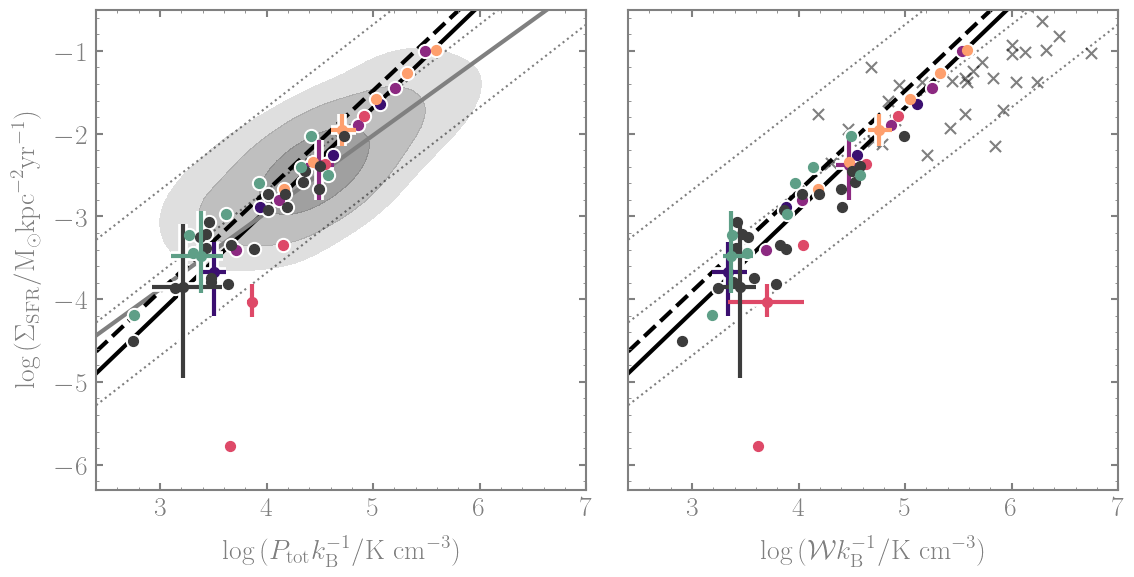

In [23]:
figW = 14
figH = 6
fig = plt.figure(figsize=(figW, figH))

topMarg = 0.1
leftMarg = 0.15
botMarg = 0.1
rightMarg = 0.15

wBetMarg = 0.03
hBetMarg = 0.01

crightMarg = 0.105
cW = 0.04
cBet = 0.02

h = (1.0-topMarg-botMarg)
w = (1.0-leftMarg-rightMarg)/2

### axes ###
ax0 = fig.add_axes([leftMarg, botMarg, w, h], xlim=[2.4, 7.], ylim=[-6.3, -0.5],
                  xlabel=r'$\log{(P_{\rm tot} k_{\rm B}^{-1}/{\rm K~cm}^{-3})}$',
                  ylabel=r'$\log{(\Sigma_{\rm SFR}/{\rm M}_\odot {\rm kpc}^{-2}{\rm yr}^{-1})}$')
ax1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg, w, h], xlim=[2.4, 7.], ylim=[-6.3, -0.5],
                  xlabel=r'$\log{(\mathcal{W} k_{\rm B}^{-1}/{\rm K~cm}^{-3})}$',
                  ylabel=r'', yticklabels='') 
axs = [ax0, ax1]

# plot stuff
# obs data
# PHANGS
density_contours.density_contour(np.log10(J23['P-DE-S20']), np.log10(J23['Sigma-SFR-HaW4recal']),
                                 xscale='linear', yscale='linear', ax=ax0,  color='grey',
                                 edgecolor='None',
                                 levels=(0.4, 0.8, 0.95), xlim=[2.4, 7.], ylim=[-6.3, -0.5])

ax1.scatter(np.log10(np.array(weights_g_ATLAS3D_RCO/ah.kB_cgs)),
                                 SFRsds_ATLAS3D_RCO, color='k', marker='x', alpha=0.5, s=64)
ax1.set_yticklabels('')
for ax in axs:
    ax.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
                   which = 'both', direction='in')
    ax.minorticks_on()

# ETGs
viridis_r_tiny = mpl.cm.ScalarMappable(norm=LogNorm(vmin=5e-4, vmax=5e-2), cmap=plt.get_cmap("viridis"))
viridis_r_tiny._A = []

# SIMULATIONS
for color, i in zip(colors, range(len(Rbin_centers))):
    ax0.scatter(np.log10(meddata_PSFRs[i]['Ptot']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=50, color=color, zorder=3)
    ax0.scatter(np.log10(meddata_PSFRs[i]['Ptot']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=100, color='white', zorder=2)

    # one error bar
    ax0.vlines(np.log10(meddata_PSFRs[i]['Ptot'][-3]), np.log10(q1data_PSFRs[i]['SigmaSFR'][-3]),
               ymax=np.log10(q4data_PSFRs[i]['SigmaSFR'][-3]), lw=3, color=color, zorder=3)
    ax0.vlines(np.log10(meddata_PSFRs[i]['Ptot'][-3]), np.log10(q1data_PSFRs[i]['SigmaSFR'][-3]),
               ymax=np.log10(q4data_PSFRs[i]['SigmaSFR'][-3]), lw=7, color='white', zorder=2)
    ax0.hlines(np.log10(meddata_PSFRs[i]['SigmaSFR'][-3]), np.log10(q1data_PSFRs[i]['Ptot'][-3]),
               xmax=np.log10(q4data_PSFRs[i]['Ptot'][-3]), lw=3, color=color, zorder=3)
    ax0.hlines(np.log10(meddata_PSFRs[i]['SigmaSFR'][-3]), np.log10(q1data_PSFRs[i]['Ptot'][-3]),
               xmax=np.log10(q4data_PSFRs[i]['Ptot'][-3]), lw=7, color='white', zorder=2)

for color, i in zip(colors, range(len(Rbin_centers))):
    ax1.scatter(np.log10(meddata[i]['Weight']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=50, color=color, zorder=3)
    ax1.scatter(np.log10(meddata[i]['Weight']), np.log10(meddata_PSFRs[i]['SigmaSFR']), s=100, color='white', zorder=2)

    # one error bar
    ax1.vlines(np.log10(meddata[i]['Weight'][-3]), np.log10(q1data_PSFRs[i]['SigmaSFR'][-3]),
               ymax=np.log10(q4data_PSFRs[i]['SigmaSFR'][-3]), lw=3, color=color, zorder=3)
    ax1.vlines(np.log10(meddata[i]['Weight'][-3]), np.log10(q1data_PSFRs[i]['SigmaSFR'][-3]),
               ymax=np.log10(q4data_PSFRs[i]['SigmaSFR'][-3]), lw=7, color='white', zorder=2)
    ax1.hlines(np.log10(meddata_PSFRs[i]['SigmaSFR'][-3]), np.log10(q1data[i]['Weight'][-3]),
               xmax=np.log10(q4data[i]['Weight'][-3]), lw=3, color=color, zorder=3)
    ax1.hlines(np.log10(meddata_PSFRs[i]['SigmaSFR'][-3]), np.log10(q1data[i]['Weight'][-3]),
               xmax=np.log10(q4data[i]['Weight'][-3]), lw=7, color='white', zorder=2)

# OBSERVATIONS AND COMPARISONS
# lines of constant Upsilon
xU = 10.**np.linspace(2.4, 7., 30)
xU_cgs = xU*ah.kB_cgs
yU_cgs = xU_cgs/(100.*1.e5)
yU_100 = yU_cgs/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s
yU_cgs = xU_cgs/(1000.*1.e5)
yU_1000 = yU_cgs/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s
yU_cgs = xU_cgs/(10000.*1.e5)
yU_10000 = yU_cgs/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s

UpsilonUT_cgs = 1.e5*(xU_cgs/ah.kB_cgs)**(-0.235)*10.**4.2
yUT = 10.**(1.235*np.log10(xU_cgs/ah.kB_cgs)-7.86)

# Sun et al. 2023 best fit, fiducial
alpha, beta = -2.95, 0.93
yUS23 = 10.**alpha * (xU_cgs/1.e4/ah.kB_cgs)**beta

# TIGRESS, Equation 25c of Ostriker & Kim 2022
UpsilonUTi_cgs = 10.**5 * 10.**(-0.212 * np.log10(xU_cgs/ah.kB_cgs) + 3.86)
yUTi_cgs = xU_cgs/UpsilonUTi_cgs
yUTi = yUTi_cgs/ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s

ax0.plot(np.log10(xU), np.log10(yU_100), color='k', ls='dotted', zorder=1, alpha=0.5)
ax0.plot(np.log10(xU), np.log10(yU_1000), color='k', ls='dotted', zorder=1, alpha=0.5)
ax0.plot(np.log10(xU), np.log10(yU_10000), color='k', ls='dotted', zorder=1, alpha=0.5)
ax0.plot(np.log10(xU), np.log10(yUT), color='k', lw=3, zorder=1)
ax0.plot(np.log10(xU), np.log10(yUS23), color='grey', lw=3, zorder=1)
ax0.plot(np.log10(xU), np.log10(yUTi), color='k', lw=3, zorder=1, ls='dashed')

# lines of constant Upsilon
ax1.plot(np.log10(xU), np.log10(yU_100), color='k', ls='dotted', zorder=1, alpha=0.5)
ax1.plot(np.log10(xU), np.log10(yU_1000), color='k', ls='dotted', zorder=1, alpha=0.5)
ax1.plot(np.log10(xU), np.log10(yU_10000), color='k', ls='dotted', zorder=1, alpha=0.5)
ax1.plot(np.log10(xU), np.log10(yUT), color='k', lw=3, zorder=1)
ax1.plot(np.log10(xU), np.log10(yUTi), color='k', lw=3, zorder=1, ls='dashed')

# legend, data
custom_lines = [Line2D([0], [0], marker='s', markeredgecolor='None', markerfacecolor='grey',
                       markersize=15, lw=0),
                Line2D([0], [0], marker='x', markeredgecolor='k',
                       markersize=12, alpha=0.5, lw=0),
                Line2D([0], [0], color='k', ls='dashed', lw=3)]
legend1 = ax1.legend(
    custom_lines, ['PHANGS, Sun et al. 2023', 'ATLAS-3D, Davis et al. 2013', 'TIGRESS, Ostriker \& Kim 2022'],
    loc='lower center', bbox_to_anchor=(-0.1, 1.01), ncol=3, frameon=False, handlelength=1, columnspacing=0.75
)

# legend, sims
custom_lines = [Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(1./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(2./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(3./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(4./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor='#3C3C3C',
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor='#5E9F87', markeredgewidth=2,
                       markeredgecolor='white', markersize=12.5, lw=3)]
legend2 = ax1.legend(
    custom_lines, [r'', r'', r'', r'ETG simulations', r'Milky Way-like', r'NGC~300-like'],
    loc='lower center', bbox_to_anchor=(-0.1, 1.1), ncol=6, frameon=False, handlelength=0.2, columnspacing=0.75
)
ax1.add_artist(legend1)
ax1.add_artist(legend2)

# plt.savefig(
#     '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/figs/obs-comparison-pressures.pdf',
#     bbox_inches='tight',
#     format='pdf'
# )

plt.show()